In [1]:
from collections import OrderedDict
import re
import os

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import torch
from tqdm.notebook import tqdm

from eval import get_run_metrics, read_run_dir, get_model_from_run, get_parrallel_model_from_run
from plot_utils import basic_plot, collect_results, relevant_model_names

%matplotlib inline
%load_ext autoreload
%autoreload 2

sns.set_theme('notebook', 'darkgrid')
palette = sns.color_palette('colorblind')

run_dir = "../models"

/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/ykwang/.conda/envs/ykwang_ICL/lib/python3.9/site-packages/transformers/utils/generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
model_name_without_label = "multiple_task_without_label"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id = "noise_reg"  # if you train more models, replace with the run_id from the table above

run_path_without_label = os.path.join(run_dir, model_name_without_label, run_id)

In [3]:
# model_name_with_label = "multiple_task_with_label_adjust_loss_weight"
model_name_with_label = "multiple_task_with_label"

task_with_label = "multiple_task_with_label"

run_id = "five_tasks"  # if you train more models, replace with the run_id from the table above

run_path_with_label = os.path.join(run_dir, model_name_with_label, run_id)

In [4]:
model_name_without_label_cat_loss = "multiple_task_without_label_cat_loss"
# model_name_with_label = "multiple_task_with_label"

task_without_label_cat_loss = "mmultiple_task_without_label_cat_loss"

run_id = "noise_reg"  # if you train more models, replace with the run_id from the table above

run_path_without_label_cat_loss = os.path.join(run_dir, model_name_without_label_cat_loss, run_id)

# Plot pre-computed metrics

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [ ]:
model_name_without_label = "multiple_task_without_label"

# model_name_without_label = "multiple_task_without_label"

task_without_label = "multiple_task_without_label"

run_id = "cube"  # if you train more models, replace with the run_id from the table above

run_path_without_label_cube = os.path.join(run_dir, model_name_without_label, run_id)

# Interactive setup

We will now directly load the model and measure its in-context learning ability on a batch of random inputs. (In the paper we average over multiple such batches to obtain better estimates.)

In [5]:
from samplers import get_data_sampler
from tasks import get_task_sampler

dwwwddddddd

In [20]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "noisy_linear_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [21]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [22]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [ ]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 0,)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [24]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 0, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_without_label_cat_loss(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [25]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(5):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 78.74609375%
Percentage of 1's: 4.9951171875%
Percentage of 2's: 7.052734375%
Percentage of 3's: 7.770507812499999%
Percentage of 4's: 1.435546875%


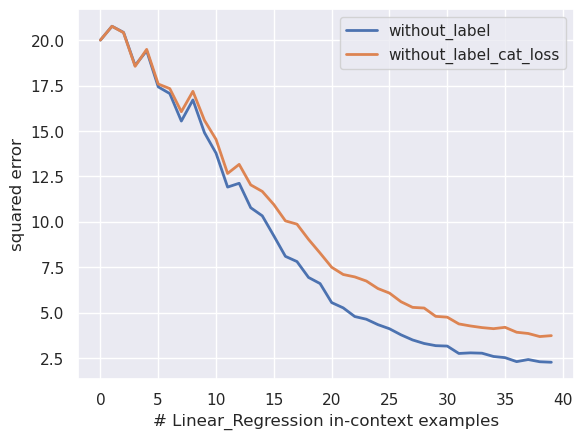

In [26]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# Linear_Regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [19]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 10

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "quadratic_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [14]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [15]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [56]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 1)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [16]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 1, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_without_label_cat_loss(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [17]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(5):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 5.826171875%
Percentage of 1's: 83.76171875%
Percentage of 2's: 5.154296875%
Percentage of 3's: 3.173828125%
Percentage of 4's: 2.083984375%


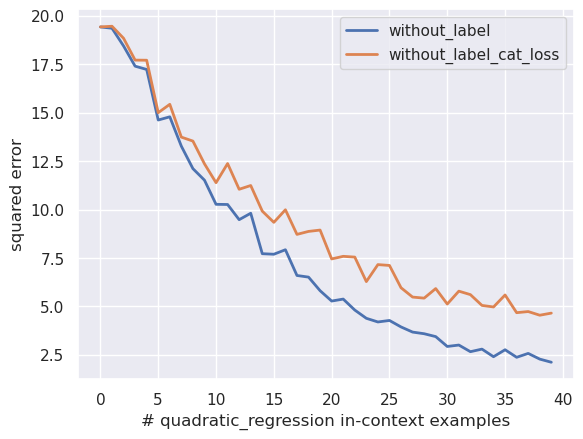

In [18]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
# plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# quadratic_regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [28]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "cube_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [29]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [30]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [31]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 2)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [32]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 2, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [33]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(5):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 6.830078125%
Percentage of 1's: 4.73046875%
Percentage of 2's: 85.693359375%
Percentage of 3's: 1.17578125%
Percentage of 4's: 1.5703124999999998%


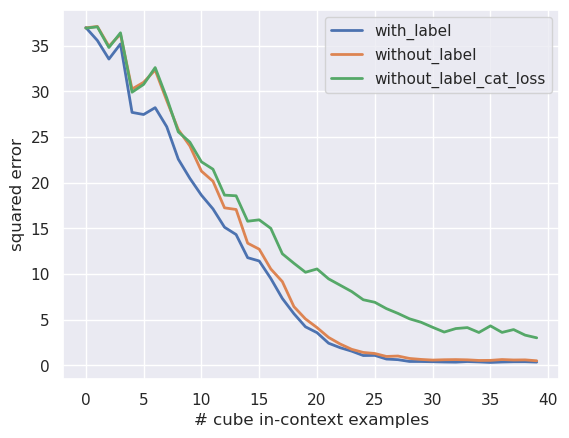

In [34]:

plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")
plt.xlabel("# cube in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [35]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "relu_2nn_regression",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
)

In [36]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [37]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [38]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 3)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [39]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 3, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [40]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(5):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of 0's: 20.8583984375%
Percentage of 1's: 10.037109375%
Percentage of 2's: 4.8046875%
Percentage of 3's: 62.5341796875%
Percentage of 4's: 1.7656249999999998%


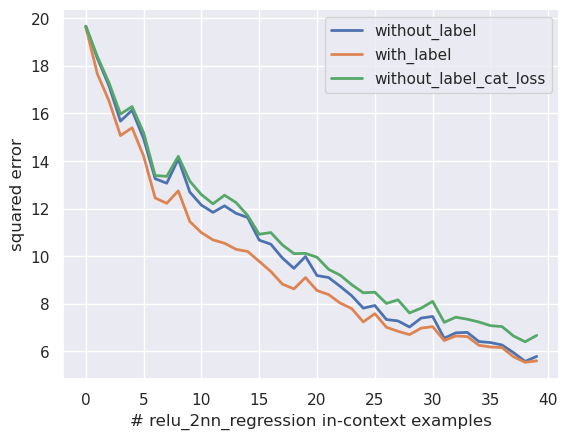

In [41]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# relu_2nn_regression in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()

In [37]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
n_dims = conf.model.n_dims
batch_size = conf.training.batch_size  * 20

data_sampler = get_data_sampler(conf.training.data, n_dims)
task_sampler = get_task_sampler(
    "decision_tree",
    n_dims,
    batch_size,
    **conf.training.task_kwargs
) 

In [38]:
task = task_sampler()
xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

In [39]:
model_without_label, conf = get_parrallel_model_from_run(run_path_without_label)
model_without_label = model_without_label.to(device)
task = task_sampler()

xs= data_sampler.sample_xs(b_size=batch_size, n_points=40).to(device)
ys = task.evaluate(xs).to(device)

with torch.no_grad():
    pred_without_label = model_without_label(xs, ys)

metric_without_label = task.get_metric()
loss_without_label = metric_without_label(pred_without_label, ys).cpu().numpy()



In [40]:
model_with_label, conf = get_parrallel_model_from_run(run_path_with_label)
model_with_label = model_with_label.to(device)

with torch.no_grad():
    pred_with_label = model_with_label(xs, ys, 4)

metric_with_label = task.get_metric()
loss_with_label = metric_with_label(pred_with_label, ys).cpu().numpy()


In [41]:
model_without_label_cat_loss, conf = get_parrallel_model_from_run(run_path_without_label_cat_loss)
model_without_label_cat_loss = model_without_label_cat_loss.to(device)

with torch.no_grad():
    pred_without_label_cat_loss = model_without_label_cat_loss(xs, ys, 4, True)

metric_without_label_cat_loss = task.get_metric()
loss_without_label_cat_loss = metric_with_label(pred_without_label_cat_loss[0], ys).cpu().numpy()

In [43]:
pred_without_label_cat_loss[1].shape
# Getting the argmax of last dimension and reshaping.
argmax = pred_without_label_cat_loss[1].argmax(dim=-1).view(-1,1)

# Total number of elements in the tensor after reshaping.
total_elements = argmax.nelement()

# Counting the occurrence of every category and getting the percentage.
for i in range(5):
    count = (argmax == i).sum().item()
    percentage = (count / total_elements) * 100
    print(f"Percentage of {i}'s: {percentage}%")

Percentage of zeros: 96.5361328125%


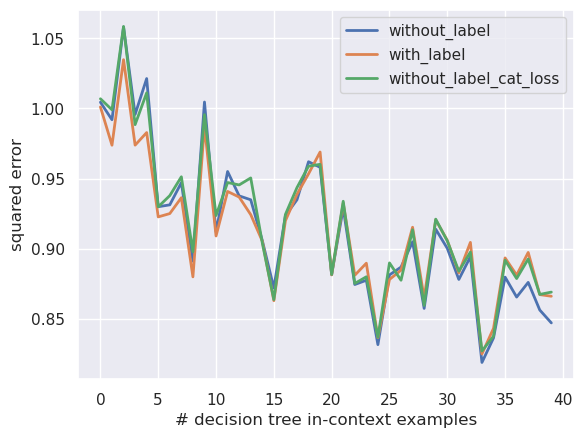

In [42]:
plt.plot(loss_without_label.mean(axis=0), lw=2, label="without_label")
plt.plot(loss_with_label.mean(axis=0), lw=2, label="with_label")
plt.plot(loss_without_label_cat_loss.mean(axis=0), lw=2, label="without_label_cat_loss")

plt.xlabel("# decision tree in-context examples")
plt.ylabel("squared error")
plt.legend()
plt.show()